In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
import numpy as np
import matplotlib.pyplot as plt
import string

# Create the dataset

In [2]:
#Create a Morse code dataset.
Morse_Dict = {"a":'.-',
              "b":'-...',
              "c":'-.-.',
              "d":'-..',
              "e":'.',
              "f":'..-.',
              "g":'--.',
              "h":'....',
              "i":'..',
              "j":'.---',
              "k":'-.-',
              "l":'.-..',
              "m":'--',
              "n":'-.',
              "o":'---',
              "p":'.--.',
              "q":'--.-',
              "r":'.-.',
              "s":'...',
              "t":'-',
              "u":'..-',
              "v":'...-',
              "w":'.--',
              "x":'-..-',
              "y":'-.--',
              "z":'--..',
              "1":'.----',
              "2":'..---',
              "3":'...--',
              "4":'....-',
              "5":'.....',
              "6":'-....',
              "7":'--...',
              "8":'---..',
              "9":'----.',
              "0":'-----',
              ".":'.-.-.-',
              ",":'--..--',
              "?":'..--..',
              ":":'---...',
              "'":'.----.',
              "-":'-....-',
              "/":'-..-.',
              "(":'-.--.',
              ")":'-.--.-',
              "\"":'.-..-.',
              "=":'-...-',
              ";":'-.-.-.',
              '$':'...-..-'}


space = 5 #Time between dots and dashes.
letter_space = 10 #Time between letters
word_space = 15 #Time between consecutive words


SpikeArray = []
New_Dataset = []
SpikeDict = {}


#Convert each Morse character into spike array
for key in Morse_Dict.keys():
    time = 0
    b= []
    for i, ch in enumerate(Morse_Dict[key]):
        if ch == '.':
            channel = 0
        elif ch =='-':
            channel = 1
        b.append((time,channel,1))
        time = time+space+1
    SpikeArray = np.array(b,dtype = [('t','<f4'),('x','<f4'),('p','<f4')])
    New_Dataset.append((SpikeArray,key))
    SpikeDict[key] = SpikeArray

In [3]:
print(SpikeArray)
print(SpikeDict.keys())

[( 0., 0., 1.) ( 6., 0., 1.) (12., 0., 1.) (18., 1., 1.) (24., 0., 1.)
 (30., 0., 1.) (36., 1., 1.)]
dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '.', ',', '?', ':', "'", '-', '/', '(', ')', '"', '=', ';', '$'])


In [4]:
#Create Morse Spike Dictionary
Morse_Spike_Dict = {}
for key in Morse_Dict.keys():
    time = 0
    b= []
    for i,ch in enumerate(Morse_Dict[key]):
        if ch == '.':
            channel = 0
        elif ch =='-':
            channel = 1
        b.append((time,channel,1))
        time = time+space+1
    SpikeArray = np.array(b,dtype = [('t','<f4'),('x','<f4'),('p','<f4')])
    Morse_Spike_Dict[key] = SpikeArray

In [5]:
Morse_Spike_Dict.keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '.', ',', '?', ':', "'", '-', '/', '(', ')', '"', '=', ';', '$'])

In [6]:
#List of top 50 words        
Top50List = ['the',
             'be',
             'to',
             'of',
             'and',
             'a',
             'in',
             'that',
             'have',
             'i',
             'it',
             'for',
             'not',
             'on',
             'with',
             'he',
             'as',
             'you',
             'do',
             'at',
             'this',
             'but',
             'his',
             'by',
             'from',
             'they',
             'we',
             'say',
             'her',
             'she',
             'or',
             'an',
             'will',
             'my',
             'one',
             'all',
             'would',
             'there',
             'their',
             'what',
             'so',
             'up',
             'out',
             'if',
             'about',
             'who',
             'get',
             'which',
             'go',
             'me']
WordDataset = []

for idx,word in enumerate(Top50List):
    time = 0
    list = []
    for i,ch in enumerate(word):
        Spikes = np.copy(SpikeDict[ch])
        Spikes['t'] += time 
        time = Spikes[-1][0]+(1+letter_space)
        list.append(Spikes)

    WholeArray = np.concatenate(list)
    WordDataset.append((WholeArray,word))

In [7]:
TrainSpikeDataset = []
training_labels = []
num_channels = 2
# Map each word to its index
word_to_index = {word: idx for idx, word in enumerate(Top50List)}

for i in range(50):
    data, label = WordDataset[i]
    training_labels.append(word_to_index.get(label))
    data_neuro = torch.zeros((int(data[-1][0])+1+word_space, num_channels))
    for idx in data: 
        # idx[0] = spike time
        # idx[1] = 0 if dot 1 if dash
        data_neuro[int(idx[0]),int(idx[1])] = 1
    TrainSpikeDataset.append(data_neuro)

In [8]:
WordDataset[-1]

(array([( 0., 1., 1.), ( 6., 1., 1.), (17., 0., 1.)],
       dtype=[('t', '<f4'), ('x', '<f4'), ('p', '<f4')]),
 'me')

## Loading test dataset (from corpus) but not loading all because it's slow :(

In [9]:
# Load a little bit of the corpus (test data)
with open('corpus.txt', 'r', encoding='utf8') as f:
    corpus = f.read().lower().split()

# Select a random subset of words from the corpus
subset_size = 100000  # Adjust this number as needed
# subset_indices = random.sample(range(len(corpus)), subset_size)
test_subset = corpus[0:subset_size]

In [10]:
# Create a translation table
translator = str.maketrans('', '', string.punctuation)

# Remove punctuation from each word
cleaned_test_subset = [word.translate(translator) for word in test_subset]

# Remove any empty strings resulting from removing punctuation-only words
cleaned_test_subset = [word for word in cleaned_test_subset if word]

In [11]:
print('Test contains:', len(cleaned_test_subset), 'words')

Test contains: 99642 words


In [12]:
# Constants (same as in the training script)
num_channels = 2  # Dots and dashes
word_space = 15  # Spacing between words
letter_space = 10  # Spacing between letters

# Map each word to its index or OOV label
word_to_index = {word: idx for idx, word in enumerate(Top50List)}
OOV_label = 50  # Label for OOV words

# Create spike trains for each word in the test subset
TestSpikeDataset = []
test_labels = []

for word in cleaned_test_subset:
    # Initialize spike train data and label
    data = []
    label = word_to_index.get(word, OOV_label)  # Assign label or OOV label
    time = 0

    # Generate spike train for the word
    for ch in word:
        if ch in Morse_Spike_Dict:
            # Retrieve the spike train for the character
            char_spikes = np.copy(Morse_Spike_Dict[ch])

            # Adjust the spike times to account for the current time
            char_spikes['t'] += time

            # Convert to the desired structured array format
            char_spikes_t_x = np.zeros(len(char_spikes), dtype=[('t', '<f4'), ('x', '<f4')])
            char_spikes_t_x['t'] = char_spikes['t']
            char_spikes_t_x['x'] = char_spikes['x']

            # Append the character's spike train to the word's data
            data.extend(char_spikes_t_x)

            # Update time for the next character
            time = char_spikes['t'][-1] + letter_space
        else:
            # Skip characters not in Morse_Spike_Dict
            continue

    # Add spacing for the next word
    if data:
        # Append the word's spike train to the dataset
        data = np.array(data, dtype=[('t', '<f4'), ('x', '<f4')])

        # Create a binary spike train tensor
        max_time = int(data[-1]['t']) + 1 + word_space  # Add word spacing
        data_neuro = torch.zeros((max_time, num_channels))  # Time x Channels

        # Populate the spike train tensor
        for idx in data:
            data_neuro[int(idx['t']), int(idx['x'])] = 1

        # Append the processed word's spike train and label
        TestSpikeDataset.append(data_neuro)
        test_labels.append(label)

### Out-of-Vocabulary (OOV) Handling

Below is an optional codeblock for if OOV is desired. My thoughts here would be to have one extra neuron that handles anytime the network sees something that is not from the top 50 words. This is a slightly more complex problem, so I trained just using the top 50 in this notebook. 

In [13]:
# # Find all indices where the label is 50 (OOV)
# oov_indices = [i for i, label in enumerate(test_labels) if label == 50]

# print(f"Total OOV samples available: {len(oov_indices)}")

# # Desired number of OOV samples to add
# desired_oov_samples = 1

# # Check if enough OOV samples are available
# if len(oov_indices) < desired_oov_samples:
#     print(f"Only {len(oov_indices)} OOV samples available. Selecting all available samples.")
#     selected_oov_indices = oov_indices  # Select all available
# else:
#     # Randomly select 10 unique indices
#     selected_oov_indices = random.sample(oov_indices, desired_oov_samples)

# print(f"Selected OOV sample indices: {selected_oov_indices}")

# # Extract spike trains for selected OOV samples
# selected_oov_spike_trains = [TestSpikeDataset[i] for i in selected_oov_indices]

# # Extract labels (all should be 50)
# selected_oov_labels = [test_labels[i] for i in selected_oov_indices]

# # Verify extraction
# print(f"Number of selected OOV spike trains: {len(selected_oov_spike_trains)}")
# print(f"Corresponding labels: {selected_oov_labels}")

# Append OOV spike trains to TrainSpikeDataset
# TrainSpikeDataset += selected_oov_spike_trains
# training_labels += selected_oov_labels

### Padding so that all the dot/dash spike trains are the same length (this makes input much easier)

In [14]:
# Determine the maximum length of spike trains
max_length = max(tensor.shape[0] for tensor in TrainSpikeDataset)

# Pad all tensors to max_length
for i in range(len(TrainSpikeDataset)):
    padding = max_length - TrainSpikeDataset[i].shape[0]
    TrainSpikeDataset[i] = F.pad(TrainSpikeDataset[i], (0, 0, 0, padding), mode='constant', value=0)  # Pad at the end

In [15]:
max_length = max(tensor.shape[0] for tensor in TestSpikeDataset)

# Pad all tensors to max_length
for i in range(len(TestSpikeDataset)):
    padding = max_length - TestSpikeDataset[i].shape[0]
    TestSpikeDataset[i] = F.pad(TestSpikeDataset[i], (0, 0, 0, padding), mode='constant', value=0)  # Pad at the end

In [16]:
# Stack all spike train tensors into a single tensor
inputs = torch.stack(TrainSpikeDataset)  # Shape: [num_words, max_length, num_channels]
test_inputs = torch.stack(TestSpikeDataset) 


# Convert labels to a torch tensor
labels = torch.tensor(training_labels)  # Shape: [num_words]
test_labels = torch.tensor(test_labels)

# Create a TensorDataset
dataset = TensorDataset(inputs, labels)
test_dataset = TensorDataset(test_inputs, test_labels)

In [17]:
# Check shapes and sample data
print("Inputs shape:", inputs.shape)  # Should be [num_words, max_length, num_channels]
print("Labels shape:", labels.shape)  # Should be [num_words]
print("Sample input tensor:", inputs[0])  # First word's spike train
print("Sample label:", labels[1])  # Corresponding label

Inputs shape: torch.Size([50, 132, 2])
Labels shape: torch.Size([50])
Sample input tensor: tensor([[0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [

# Training the network

In [18]:
# Parameters
spike_grad = surrogate.fast_sigmoid(slope=15)
beta = 0.8
num_channels = 2  # Dots and dashes
learning_rate = 1e-3
num_epochs = 2000

# Create DataLoader
batch_size = 50
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
test_accuracies = []

# --- Step 2: Define the SNN Model ---
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_channels, 128)  # Input: num_channels, Output: 128
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_threshold=True, learn_beta=True)
        self.fc2 = nn.Linear(128, 256)  # Input: 128, Output: 64
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_threshold=True, learn_beta=True)
        self.fc3 = nn.Linear(256, 50)  # Output: 50 classes
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_threshold=True, learn_beta=True)

    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk1_rec, spk2_rec, spk3_rec = [], [], []

        for t in range(x.size(1)):  # Iterate through time steps
            cur1 = self.fc1(x[:, t, :])  # Linear layer
            spk1, mem1 = self.lif1(cur1, mem1)  # Spiking activation
            spk1_rec.append(spk1)

            cur2 = self.fc2(spk1)  # Linear layer
            spk2, mem2 = self.lif2(cur2, mem2)  # Spiking activation
            spk2_rec.append(spk2)

            cur3 = self.fc3(spk2)  # Linear layer
            spk3, mem3 = self.lif3(cur3, mem3)  # Spiking activation
            spk3_rec.append(spk3)

        spk3_rec = torch.stack(spk3_rec, dim=1)
        return spk3_rec.mean(dim=1)  # Aggregate spikes over time

# Initialize the model
model = Net()

# --- Step 3: Define Training Pipeline ---
criterion = nn.CrossEntropyLoss()  # Loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for data, target in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# --- Step 4: Evaluation ---
def evaluate_model(loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            outputs = model(data)
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate the model on the training set (or validation/test set if available)
accuracy = evaluate_model(train_loader)
print(f"Train accuracy: {accuracy:.2f}%")

Epoch 1/2000, Loss: 3.9120
Epoch 2/2000, Loss: 3.9120
Epoch 3/2000, Loss: 3.9120
Epoch 4/2000, Loss: 3.9120
Epoch 5/2000, Loss: 3.9120
Epoch 6/2000, Loss: 3.9120
Epoch 7/2000, Loss: 3.9120
Epoch 8/2000, Loss: 3.9120
Epoch 9/2000, Loss: 3.9120
Epoch 10/2000, Loss: 3.9120
Epoch 11/2000, Loss: 3.9119
Epoch 12/2000, Loss: 3.9119
Epoch 13/2000, Loss: 3.9119
Epoch 14/2000, Loss: 3.9114
Epoch 15/2000, Loss: 3.9114
Epoch 16/2000, Loss: 3.9112
Epoch 17/2000, Loss: 3.9109
Epoch 18/2000, Loss: 3.9106
Epoch 19/2000, Loss: 3.9106
Epoch 20/2000, Loss: 3.9104
Epoch 21/2000, Loss: 3.9099
Epoch 22/2000, Loss: 3.9098
Epoch 23/2000, Loss: 3.9092
Epoch 24/2000, Loss: 3.9086
Epoch 25/2000, Loss: 3.9084
Epoch 26/2000, Loss: 3.9069
Epoch 27/2000, Loss: 3.9083
Epoch 28/2000, Loss: 3.9060
Epoch 29/2000, Loss: 3.9055
Epoch 30/2000, Loss: 3.9046
Epoch 31/2000, Loss: 3.9033
Epoch 32/2000, Loss: 3.9039
Epoch 33/2000, Loss: 3.9022
Epoch 34/2000, Loss: 3.9012
Epoch 35/2000, Loss: 3.9004
Epoch 36/2000, Loss: 3.8991
E

# Testing the network

First, we test just using the filtered corpus (no punctuation) that we have created. But of course this is a little janky because we will have OOV words that we have not handled at all. 

In [19]:
test_accuracy = evaluate_model(test_loader)
print(f"Test accuracy: {test_accuracy:.2f}%")

Accuracy: 4.25%
Test accuracy: 4.25%


Below is testing using the vocabulary but with any OOV words removed. This still feels somewhat wrong though because all this data is essentially in the exact same form as the training data was, there is just an imbalance in terms of how often a word is seen. I think we may need to dig deeper into what architecture is appropriate here and what the ultimate goal is. For example, should we rather be doing latency coding? Where the first spike to fire corresponds to a class as was more so what Ben was doing in his STDP example. If we go this direction though we would have to rethink training, as I don't think taking a classification type problem then moving to a continuous stream of data makes sense. We have to match training and test more closely. Also, ultimately latency coding is a trickier problem.

In general, this is a tricky problem to approach since we only have 50 training examples which is very little data for classification. Next steps could be to augment the dataset with noise (as Ben has already done, but probably more noisy data), then align on network architecture/what kind of task we want to be done.

In [20]:
# Create a boolean mask where labels are not equal to 50
non_oov_mask = test_labels != 50

# Apply the mask to filter test_inputs and test_labels
filtered_test_inputs = test_inputs[non_oov_mask]
filtered_test_labels = test_labels[non_oov_mask]

# Create a new TensorDataset with the filtered data
filtered_test_dataset = TensorDataset(filtered_test_inputs, filtered_test_labels)

# Create a new DataLoader for the filtered test dataset
filtered_test_loader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False)

test_accuracy = evaluate_model(filtered_test_loader)
print(f"Filtered Test accuracy: {test_accuracy:.2f}%")

Accuracy: 12.46%
Filtered Test accuracy: 12.46%


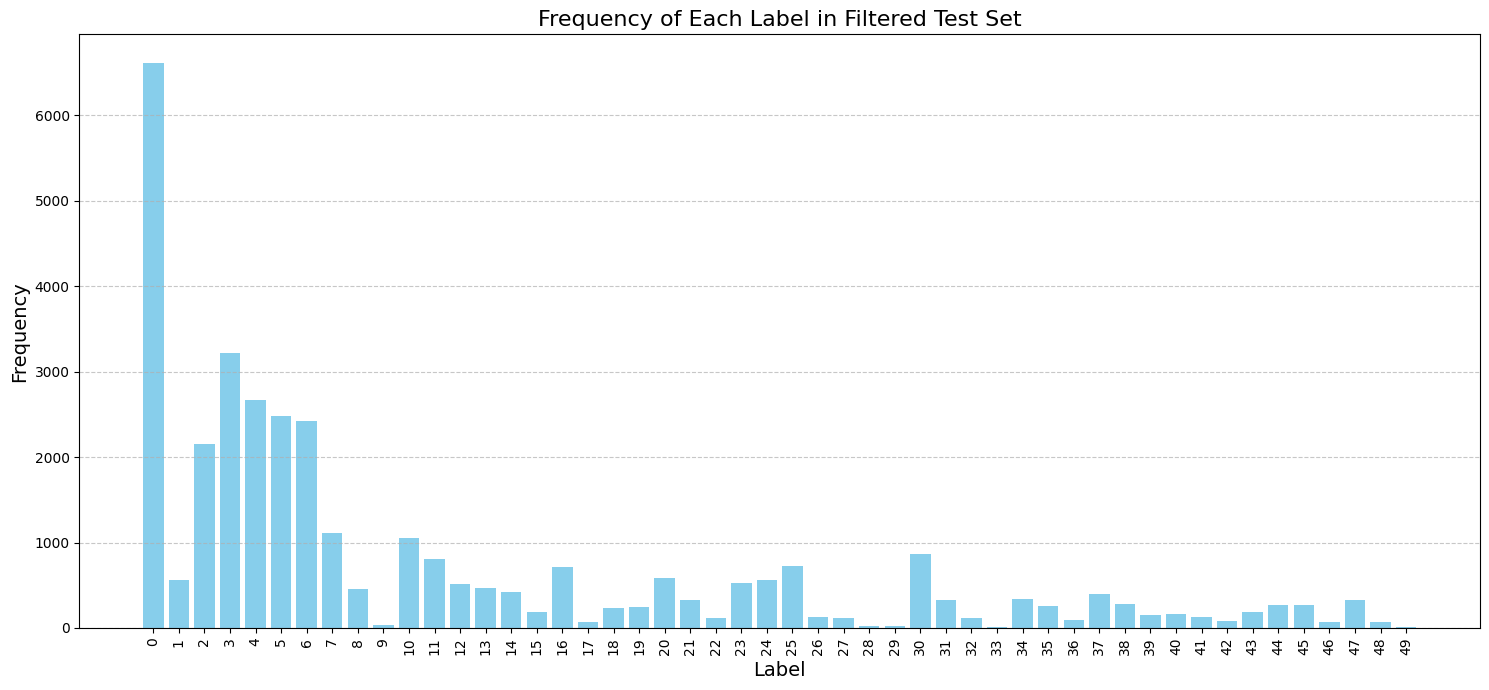

In [21]:
# Convert filtered_test_labels to a NumPy array for easier manipulation
labels = filtered_test_labels.numpy()

# Count the frequency of each label from 0 to 49
counts = np.bincount(labels, minlength=50)

# Define label range
label_range = range(50)  # Labels 0 to 49

# Create a figure and axis
plt.figure(figsize=(15, 7))  # Adjust the size as needed

# Create the bar chart
plt.bar(label_range, counts, color='skyblue')

# Add labels and title
plt.xlabel('Label', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Frequency of Each Label in Filtered Test Set', fontsize=16)

# Set x-ticks to show every label (0-49)
plt.xticks(label_range, rotation=90)  # Rotate labels for better readability

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()

# Display the plot
plt.show()